In [1]:
import pdb
import pickle
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

import nltk
nltk.download('stopwords')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from fastprogress import progress_bar
from nltk.corpus import stopwords
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from string import punctuation

from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     /s/chopin/l/grad/fahadktk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
torch.__version__

'1.2.0'

In [3]:
class IMDBDataset(Dataset):
    def __init__(self, file_path, min_len=10, max_len=300, embedding='default', remove_stopWords=True, device=None):
        self.max_len = max_len
        self.min_len = min_len
        self.data = pd.read_csv(file_path)
        if 'sentiment' in self.data.columns:
            self.data['label'] = self.data.sentiment.apply(lambda x: 1 if x=='positive' else 0)
            self.data = self.data[['review', 'label']]
        #self.data['label'] = self.data['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
        self.data['review'] = self.data.review.apply(lambda x: x.replace('<br />', ''))
        stop_words = set(stopwords.words('english'))
        if remove_stopWords:
            self.data['review'] = self.data.review.apply(lambda x: ' '.join([c for c in x.split() if c not in stop_words]))
        self.data['review'] = self.data.review.apply(lambda x: ''.join([c for c in x if c not in punctuation]))
        self.data['reviewLen'] = self.data.review.apply(lambda x: len([c for c in x.split()]))
        self.data = self.data[self.data['reviewLen'].isin([i for i in range(self.min_len, self.max_len)])].reset_index()    
        if embedding=='default':
            self.word_to_ix = {}
            for review in self.data['review']:
                for word in review.split():
                    if word not in self.word_to_ix:
                        self.word_to_ix[word] = len(self.word_to_ix)+1 #0 is for paddings
        self.tag_to_ix = {"1":1, "0":0}
    
    def __len__(self):
        return len(self.data)
    
    def pad_data(self, s):
        padded = np.zeros((self.max_len,),dtype=np.int64)
        if len(s) > self.max_len: padded[:] = s[:self.max_len]
        else: padded[:len(s)] = s
        return padded

    def __getitem__(self, index):
        review = self.data['review'][index]
        label = self.data['label'][index]
        idxs = [self.word_to_ix[w] for w in review.split()]
        lenReview = self.data['reviewLen'][index]#min(len(idxs), self.max_len)
        idxs = self.pad_data(idxs)
        review = torch.tensor(idxs, dtype=torch.long)
        #label = self.tag_to_ix[label]
        label = torch.tensor(label, dtype=torch.long)
        return review, label, lenReview

In [4]:
class IMDBDatasetv2(Dataset):
    def __init__(self, file_path, min_len=10, max_len=300, embedding='default', remove_stopWords=True, device=None):
        self.max_len = max_len
        self.min_len = min_len
        self.data = pd.read_csv(file_path)
        if 'sentiment' in self.data.columns:
            self.data['label'] = self.data.sentiment.apply(lambda x: 1 if x=='positive' else 0)
            self.data = self.data[['review', 'label']]
        #self.data['label'] = self.data['sentiment'].apply(lambda x: "1" if x=='positive' else "0")
        self.data['review'] = self.data.review.apply(lambda x: x.replace('<br />', ''))
        stop_words = set(stopwords.words('english'))
        if remove_stopWords:
            self.data['review'] = self.data.review.apply(lambda x: ' '.join([c for c in x.split() if c not in stop_words]))
        self.data['review'] = self.data.review.apply(lambda x: ''.join([c for c in x if c not in punctuation]))
        self.data['reviewLen'] = self.data.review.apply(lambda x: len([c for c in x.split()]))
        self.data = self.data[self.data['reviewLen'].isin([i for i in range(self.min_len, self.max_len)])].reset_index()    
        if embedding=='default':
            self.word_to_ix = {}
            for review in self.data['review']:
                for word in review.split():
                    if word not in self.word_to_ix:
                        self.word_to_ix[word] = len(self.word_to_ix)+1 #0 is for paddings
            self.tag_to_ix = {"1":1, "0":0}
        self.idx_list = []
        self.lenReview_list = []
        self.label_list = []
        self.IDs_list = []
        print('Generating data tensors...')
        for i in progress_bar(range(0, self.data.shape[0])):
            self.IDs_list.append(i)
            review = self.data['review'][i]
            label = self.data['label'][i]
            
            idxs = [self.word_to_ix[w] for w in review.split()]
            lenReview = min(len(idxs), self.max_len) #self.data['reviewLen'][i]#min(len(idxs), self.max_len)
            idxs = self.pad_data(idxs)
            
            review = torch.tensor(idxs, dtype=torch.long)
            self.idx_list.append(review)
            #label = self.tag_to_ix[label]
            label = torch.tensor(label, dtype=torch.long)
            self.label_list.append(label)
            lenReview = torch.tensor(lenReview, dtype=torch.long)
            self.lenReview_list.append(lenReview)
            
            
    
    def __len__(self):
        return len(self.data)
    
    def pad_data(self, s):
        padded = np.zeros((self.max_len,),dtype=np.int64)
        if len(s) > self.max_len: padded[:] = s[:self.max_len]
        else: padded[:len(s)] = s
        return padded

    def __getitem__(self, index):
        return self.IDs_list[index], self.idx_list[index], self.label_list[index], self.lenReview_list[index]
        

In [5]:
class ModelIMDB(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(ModelIMDB, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        #self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.lstm = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.target = nn.Linear(hidden_dim, tagset_size)
    
    def forward(self, review, lengths):
        #pdb.set_trace()
        self.embs = self.word_embeddings(review)
        self.embspack = pack_padded_sequence(self.embs, lengths, batch_first=True)
        #lstm_out, self.h = self.lstm(self.embspack)
        lstm_out, self.h = self.lstm(self.embspack)
        
        #outp = self.target(self.h[0]) #[hidden state, cell state]
        outp = self.target(self.h)
        return outp

In [48]:
nheads = 2

class PositionalEncoding(nn.Module):
    # Taken from: https://nlp.seas.harvard.edu/2018/04/03/attention.html
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
       
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
       
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)],
                         requires_grad=False)
        return self.dropout(x)

class ModelIMDBaAttention(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, device):
        super(ModelIMDBaAttention, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.usepooling = False
        self.readout_strategy = 'normalize'
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.pe = PositionalEncoding(d_model=embedding_dim, dropout=0.1)
        self.Q = nn.ModuleList([nn.Linear(in_features=embedding_dim, out_features=hidden_dim) for i in range(0,nheads)])
        self.K = nn.ModuleList([nn.Linear(in_features=embedding_dim, out_features=hidden_dim) for i in range(0,nheads)])
        self.V = nn.ModuleList([nn.Linear(in_features=embedding_dim, out_features=hidden_dim) for i in range(0,nheads)])
        self.RELU = nn.ModuleList([nn.ReLU() for i in range(0,nheads)])
        self.MultiHeadLinear = nn.Linear(in_features=hidden_dim*nheads, out_features=100)#50
        self.MHReLU = nn.ReLU()
        
        self.target = nn.Linear(100, tagset_size)
    
    def attention(self, query, key, value, mask=None, dropout=0.0):
        #based on: https://nlp.seas.harvard.edu/2018/04/03/attention.html
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        #p_attn_pos = torch.tanh(scores)
        #p_attn_neg = torch.tanh(scores)
        p_attn_pos = F.softmax(scores, dim = -1)
        p_attn_neg = F.softmin(scores, dim = -1)
        p_attn = (p_attn_pos + p_attn_neg)/2
        #p_attn = F.softmax(scores, dim=-1)
        p_attn = F.dropout(p_attn, p=dropout,training=self.training)
        return torch.matmul(p_attn, value), [p_attn_pos, p_attn_neg]
    
    def forward(self, review, lengths):
        #pdb.set_trace()
        self.embs = self.word_embeddings(review)
        output = self.pe(self.embs)
        #self.embs = pack_padded_sequence(self.embs, lengths, batch_first=True)
        #output = self.embs
        attn_concat = torch.Tensor([]).to(self.device)
        pAttn_concat_pos = torch.Tensor([]).to(self.device)
        pAttn_concat_neg = torch.Tensor([]).to(self.device)
        for i in range(0,nheads):
            query, key, value = self.Q[i](output), self.K[i](output), self.V[i](output)
            attnOut,p_attn = self.attention(query, key, value, dropout=0.2)
            attnOut = self.RELU[i](attnOut)
            if self.usepooling:
                attnOut = self.MAXPOOL[i](attnOut.permute(0,2,1)).permute(0,2,1)
            attn_concat = torch.cat((attn_concat,attnOut),dim=2)
            pAttn_concat_pos = torch.cat((pAttn_concat_pos, p_attn[0]), dim=2)
            pAttn_concat_neg = torch.cat((pAttn_concat_neg, p_attn[1]), dim=2)
        pAttn_concat = [pAttn_concat_pos, pAttn_concat_neg]
        output = self.MultiHeadLinear(attn_concat)
        output = self.MHReLU(output)

        if self.readout_strategy == 'normalize':
            output = output.sum(axis=1)
            output = (output-output.mean())/output.std()
        
        #outp = self.target(self.h[0]) #[hidden state, cell state]
        outp = self.target(output)
        return outp, pAttn_concat

In [7]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_auc = 0
    epoch_f1 = 0
    model.train()
    for batch in progress_bar(iterator):
        #pdb.set_trace()
        optimizer.zero_grad()
        _, text,labels,lengths = batch
        lengths_Argsorted = lengths.argsort(descending=True)
        lengths = lengths[lengths_Argsorted]
        text = text[lengths_Argsorted]
        labels = labels[lengths_Argsorted]
        text = text.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)
        outputs,_ = model(text, lengths)
        outputs  = outputs.squeeze()
        loss = criterion(outputs, labels)
        softmax = torch.nn.Softmax(dim=1)
        labels = labels.cpu().detach().numpy()
        predictions = softmax(outputs).cpu().detach().numpy()
        auc = metrics.roc_auc_score(labels, predictions[:,-1])
        f1 = metrics.f1_score(labels, np.round(predictions[:,-1]))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_auc += auc
        epoch_f1 += f1
    return epoch_loss/len(iterator), epoch_auc/len(iterator), epoch_f1/len(iterator)

In [8]:
def evaluate(model, iterator, criterion, device, store_pattn=False):
    epoch_loss = 0
    epoch_auc = 0
    epoch_f1 = 0
    model.eval()
    res_pred = {}

    with torch.no_grad():
        count = 0
        for batch in progress_bar(iterator):
            #pdb.set_trace()
            indx, text,labels,lengths = batch
            lengths_Argsorted = lengths.argsort(descending=True)
            indx = indx[lengths_Argsorted]
            lengths = lengths[lengths_Argsorted]
            text = text[lengths_Argsorted]
            labels = labels[lengths_Argsorted]
            text = text.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)
            outputs,attn = model(text, lengths)
            indx = indx.cpu().detach().numpy()
            if store_pattn:
                 with open(f'attn_dir/attention_dict_{count}.pckl','wb') as f:
                    pickle.dump([indx, attn], f)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels)
            softmax = torch.nn.Softmax(dim=1)
            
            labels = labels.cpu().detach().numpy()
            predictions = softmax(outputs).cpu().detach().numpy()
            res_pred[count] = [indx, labels, predictions]
            
            auc = metrics.roc_auc_score(labels, predictions[:,-1])
            f1 = metrics.f1_score(labels, np.round(predictions[:,-1]))

            epoch_loss += loss.item()
            epoch_auc += auc
            epoch_f1 += f1
            count += 1
        
    return res_pred, epoch_loss/len(iterator), epoch_auc/len(iterator), epoch_f1/len(iterator)

In [49]:
batch_size = 64
test_split = 0.1
shuffle_data = True
rand_seed = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [50]:
dataset = IMDBDatasetv2('IMDB_Dataset.csv', device=device, remove_stopWords=True)

Generating data tensors...


In [51]:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split_val = int(np.floor(test_split*dataset_size))
if shuffle_data:
    np.random.seed(rand_seed)
    np.random.shuffle(indices)
train_indices, test_indices, valid_indices = np.array(indices[2*split_val:]),np.array(indices[:split_val]),np.array(indices[split_val:2*split_val])
#train_indices, valid_indices = indices[split_val:], indices[:split_val]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
train_loader = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler, num_workers = 8, drop_last=True)
test_loader = DataLoader(dataset, batch_size = batch_size, sampler = test_sampler, num_workers = 8, drop_last=True)
valid_loader = DataLoader(dataset, batch_size = batch_size, sampler = valid_sampler, num_workers = 8, drop_last=True)

In [52]:
#len(indices[2*split_val:])
len(train_indices)

37249

In [53]:
len(dataset.word_to_ix)

220394

In [54]:
#model = ModelIMDB(100, 50, len(dataset.word_to_ix)+1, len(dataset.tag_to_ix)).to(device)
model = ModelIMDBaAttention(100, 50, len(dataset.word_to_ix)+1, len(dataset.tag_to_ix), device).to(device)
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters())

In [55]:
#model

In [56]:
N_EPOCHS = 15
best_valid_loss = float('inf')
best_valid_auc = float('inf')
best_valid_f1 = float('inf')
for epoch in range(N_EPOCHS):
    train_loss, train_auc, train_f1 = train(model, train_loader, optimizer, criterion, device)
    _, valid_loss, valid_auc, valid_f1 = evaluate(model, valid_loader, criterion, device)
    print(train_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_auc = valid_auc
        best_valid_f1 = valid_f1
        print("Best Validation Loss: %.3f, AUC: %.2f, F1:%.2f"%(best_valid_loss, best_valid_auc, best_valid_f1), "\n")
        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'loss':valid_loss
                    },
                   'saved_model')

0.5183672794873772
Best Validation Loss: 0.375, AUC: 0.91, F1:0.83 



0.329122676011623
Best Validation Loss: 0.303, AUC: 0.94, F1:0.88 



0.2361331003945308


0.17522015976255498
Best Validation Loss: 0.297, AUC: 0.95, F1:0.89 



0.1283337363486796


0.09109091511015426


0.06664220620862038


0.048692439572367165


0.036901942465479946


0.026975358493907756


0.024975550637814085


0.020384710614931134


0.018170271153622578


0.012991722846000465


0.013814518532213271


In [57]:
try:    
    checkpoint = torch.load('saved_model')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
except:
    print("No pre-trained model found at! Please run with --mode set to train.")

In [58]:
res_pred, valid_loss, valid_auc, valid_f1 = evaluate(model, valid_loader, criterion, device, store_pattn=True)

In [59]:
valid_loss, valid_auc, valid_f1

(0.3000409336139758, 0.9544247204642721, 0.8836741003866616)

In [60]:
for key,val in res_pred.items():
    with open(f'attn_dir/attention_dict_{key}.pckl','rb') as f:
        attn_dict = pickle.load(f)
        break

In [61]:
np.round(val[2][:,-1])==val[1]

array([ True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [62]:
inx = 3
val[0][inx], val[1][inx], val[2][inx]

(43314, 1, array([0.07587618, 0.92412376], dtype=float32))

In [63]:
attn_dict[0][inx]

43314

In [64]:
dataset.data.iloc[val[0][inx]]

index                                                    46535
review       The unlikely duo Zero Mostel Harry Belafonte t...
label                                                        1
reviewLen                                                  211
Name: 43314, dtype: object

In [65]:
attn_mat = attn_dict[1][0][inx].cpu().detach().numpy()
attn_mat = np.asarray([attn_mat[:,300*i:300*(i+1)] for i in range(0,nheads)]) 
attn_mat = np.max(attn_mat, axis=0)
review,review_len = dataset.data.iloc[val[0][inx]][['review','reviewLen']]
attn_mat = attn_mat[:review_len, :review_len]
review = review.split()
arg_max_attn = np.unravel_index(np.argsort(attn_mat, axis=None)[::-1], attn_mat.shape)
count = 0
for i,j in zip(arg_max_attn[0], arg_max_attn[1]):
    if i==j:
        continue
    print(i,review[i], j,review[j], attn_mat[i,j])
    count += 1
    if count > 60:
        break

127 car 35 poor 0.9261247
122 know 35 poor 0.89072704
112 hes 160 Main 0.8804458
98 deceased 35 poor 0.8728056
102 given 160 Main 0.8718216
52 applying 35 poor 0.85668176
82 him 86 coil 0.8361075
109 hes 160 Main 0.8219691
110 moved 35 poor 0.8163658
159 Shop 35 poor 0.7983495
123 hes 160 Main 0.7736151
23 A 160 Main 0.7428809
204 writer 35 poor 0.72027194
198 brought 34 Jewish 0.7188338
209 catch 35 poor 0.6931501
106 given 160 Main 0.69164616
176 OSheas 86 coil 0.6654493
95 quite 160 Main 0.6579198
112 hes 35 poor 0.6467937
118 also 69 might 0.64225394
109 hes 35 poor 0.6416884
187 doctorThe 35 poor 0.5738986
105 angels 160 Main 0.5622782
98 deceased 160 Main 0.5563858
206 Malamud 51 reduced 0.5559434
79 one 143 believe 0.5498645
50 Hes 35 poor 0.5496518
34 Jewish 80 thing 0.54925805
151 actress 86 coil 0.53115577
123 hes 35 poor 0.5149714
107 assignmentBelafonte 35 poor 0.51206225
91 God 160 Main 0.49904802
53 welfare 38 Mostel 0.4986911
117 He 160 Main 0.49814782
194 faith 35 poor 

In [66]:
' '.join(review)

'The unlikely duo Zero Mostel Harry Belafonte team give us interesting performances subject matter The Angel Levine Its one interesting twist themes Its A Wonderful LifeZero married Ida Kaminsky two belong special class elderly Jewish poor New York Mostel used tailor proud trade back arthritis prevented working Kaminsky mostly bedridden Hes reduced applying welfare In desperation like Jimmy Stewart cries God helpNow maybe gotten someone like Henry Travers things might worked differently even Stewart trouble accepting Travers But Travers one thing going him 100 years mortal coil ties earthly things gone God sent Mostel something quite different recently deceased Harry Belafonte least given basic training angels given assignmentBelafonte accepted hes moved life hes still got lot issues He also wife Gloria Foster know hes passed on hit car right beginning film You put issues Mostels issues got good conflict starting fact Mostel cant believe black Jew named LevineThis farewell performance 

In [67]:
attn_mat = attn_dict[1][1][inx].cpu().detach().numpy()
attn_mat = np.asarray([attn_mat[:,300*i:300*(i+1)] for i in range(0,nheads)]) 
attn_mat = np.max(attn_mat, axis=0)
review,review_len = dataset.data.iloc[val[0][inx]][['review','reviewLen']]
attn_mat = attn_mat[:review_len, :review_len]
review = review.split()
#arg_max_attn = np.unravel_index(np.argsort(attn_mat, axis=None)[::-1], attn_mat.shape)
arg_max_attn = np.unravel_index(np.argsort(attn_mat, axis=None), attn_mat.shape)
count = 0
for i,j in zip(arg_max_attn[0], arg_max_attn[1]):
    if i==j:
        continue
    print(i,review[i], j,review[j], attn_mat[i,j])
    count += 1
    if count > 60:
        break

180 I 138 conflict 1.7121938e-07
180 I 155 nomination 2.4209595e-07
62 maybe 73 Stewart 2.8434465e-07
180 I 187 doctorThe 3.5159556e-07
180 I 140 fact 3.9833876e-07
180 I 172 nice 7.8372165e-07
98 deceased 51 reduced 8.426909e-07
98 deceased 172 nice 8.632352e-07
180 I 51 reduced 9.19613e-07
62 maybe 58 Stewart 9.673053e-07
180 I 174 doctor 1.0550746e-06
180 I 30 belong 1.1459226e-06
180 I 98 deceased 1.1487467e-06
180 I 182 surprised 1.221579e-06
179 Verdict 51 reduced 1.273461e-06
180 I 114 got 1.3008306e-06
62 maybe 69 might 1.5409815e-06
180 I 181 really 1.7765907e-06
180 I 19 interesting 1.8140744e-06
180 I 160 Main 1.8733942e-06
38 Mostel 34 Jewish 2.0159157e-06
180 I 57 Jimmy 2.0390032e-06
62 maybe 61 helpNow 2.0879072e-06
3 Zero 108 accepted 2.1762962e-06
1 unlikely 51 reduced 2.3488547e-06
38 Mostel 173 Jewish 2.3721147e-06
50 Hes 177 brogue 2.4165874e-06
89 things 198 brought 2.4348349e-06
112 hes 172 nice 2.655348e-06
159 Shop 172 nice 2.7099686e-06
93 Mostel 34 Jewish 2.867

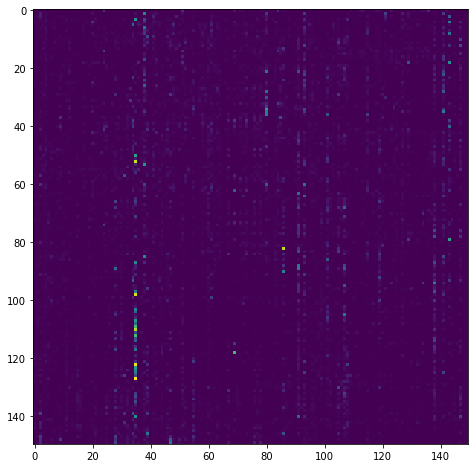

In [68]:
attn_mat = attn_dict[1][0][inx].cpu().detach().numpy()
attn_mat = np.asarray([attn_mat[:,300*i:300*(i+1)] for i in range(0,nheads)]) 
attn_mat = np.max(attn_mat, axis=0)
plt.figure(figsize=(8,8))
plt.imshow(attn_mat[:150, :150])

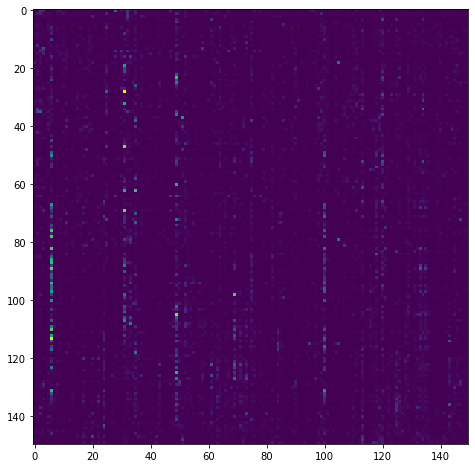

In [69]:
attn_mat = attn_dict[1][1][inx].cpu().detach().numpy()
attn_mat = np.asarray([attn_mat[:,300*i:300*(i+1)] for i in range(0,nheads)]) 
attn_mat = np.max(attn_mat, axis=0)
plt.figure(figsize=(8,8))
plt.imshow(attn_mat[:150, :150])

In [70]:
attn_mat = attn_dict[1][0][inx].cpu().detach().numpy()
attn_mat = np.asarray([attn_mat[:,300*i:300*(i+1)] for i in range(0,nheads)]) 
attn_mat = np.max(attn_mat, axis=0)
review,review_len = dataset.data.iloc[val[0][inx]][['review','reviewLen']]
attn_mat = attn_mat[:review_len, :review_len]
review = review.split()
attn_mat = attn_mat.mean(axis=1)
arg_max_attn = np.argsort(attn_mat)[::-1]

count = 0
for i in arg_max_attn:
    print(i, review[i])
    count += 1
    if count > 30:
        break

98 deceased
180 I
82 him
89 things
112 hes
159 Shop
110 moved
127 car
1 unlikely
52 applying
60 God
123 hes
34 Jewish
109 hes
107 assignmentBelafonte
23 A
91 God
36 New
187 doctorThe
87 ties
35 poor
166 role
21 themes
113 still
168 actor
68 things
105 angels
40 tailor
117 He
179 Verdict
88 earthly


In [71]:
attn_mat = attn_dict[1][1][inx].cpu().detach().numpy()
attn_mat = np.asarray([attn_mat[:,300*i:300*(i+1)] for i in range(0,nheads)]) 
attn_mat = np.max(attn_mat, axis=0)
review,review_len = dataset.data.iloc[val[0][inx]][['review','reviewLen']]
attn_mat = attn_mat[:review_len, :review_len]
review = review.split()
attn_mat = attn_mat.mean(axis=1)
arg_max_attn = np.argsort(attn_mat)[::-1]

count = 0
for i in arg_max_attn:
    print(i, review[i])
    count += 1
    if count > 30:
        break

180 I
91 God
60 God
98 deceased
87 ties
89 things
94 something
62 maybe
112 hes
113 still
97 recently
110 moved
179 Verdict
82 him
159 Shop
93 Mostel
168 actor
50 Hes
123 hes
125 on
102 given
107 assignmentBelafonte
170 OShea
1 unlikely
109 hes
72 even
3 Zero
106 given
18 one
79 one
23 A
